In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import numpy as np
import os
import glob
import matplotlib.pyplot as plt
from scipy.signal import butter, lfilter

In [ ]:
# Initialize empty lists to store data and corresponding folder names
all_data = []
all_names = []

# Specify the path to the data folder
data_folder = '/content/drive/MyDrive/FDA Project/data'

# Loop through each folder in the data directory
for folder in os.listdir(data_folder):
    folder_path = os.path.join(data_folder, folder)

    # Loop through each text file in the current folder
    for file in glob.glob(os.path.join(folder_path, '*.txt')):
        # Load data from the text file using NumPy
        data = np.loadtxt(file)

        # Append the data and folder name to the respective lists
        all_data.append(data)
        all_names.append(folder)

# Convert the list of data arrays into a NumPy array
all_data = np.array(all_data)


In [ ]:
# Create a list 'labels' initialized with zeros, having the same length as 'all_names'
labels = [0 for i in range(len(all_names))]

# Iterate through each index in the range of the length of 'all_names'
for i in range(0, len(all_names)):
    # Check if the character at the current index in 'all_names' is either "Z" or "O"
    if all_names[i] == "Z" or all_names[i] == "O":
        # If true, set the corresponding element in 'labels' to 0 (healthy)
        labels[i] = 0
    else:
        # If false, set the corresponding element in 'labels' to 1 (seizure)
        labels[i] = 1

- z - healthy
- o - healthy
- n - Mild Seizure
- f - Mild Seizure
- s - Seizure

In [ ]:
tri_labels = [0 for i in range(len(all_names))]
for i in range(0,len(all_names)):
    if all_names[i]=="Z" or all_names[i]=="O":
        tri_labels[i]=0
    elif all_names[i]=="F" or all_names[i]=="N":
        tri_labels[i]=1
    else:
        tri_labels[i]=2

In [ ]:
all_data.shape

(500, 4097)

## Preprocessing

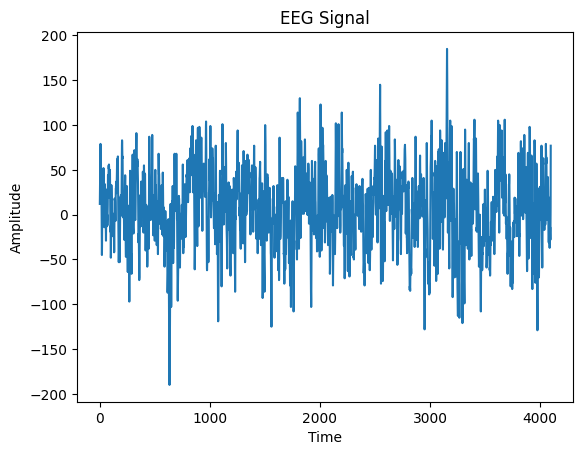

In [ ]:
plt.plot(all_data[0])
plt.title("EEG Signal")
plt.xlabel("Time")
plt.ylabel("Amplitude")
plt.show()

In [ ]:
# 1. Bandpass filtering: Remove noise outside the EEG frequency range (0.5-40 Hz)
lowcut = 0.5
highcut = 40
fs = 173.61  # Sampling rate (Hz)
order = 5

# Design a butterworth bandpass filter
b, a = butter(order, [lowcut / fs * 2, highcut / fs * 2], btype='bandpass')

# Filter the data
filtered_data = lfilter(b, a, all_data)

In [ ]:
filtered_data

array([[  0.43754614,   3.14578761,  10.45898472, ..., -32.93389323,
        -33.96813192, -21.21705813],
       [ -2.04188201, -12.76000077, -34.90079925, ..., -40.29879869,
        -39.84024079, -28.30967975],
       [ -1.34910061,  -8.02832861, -19.98219132, ...,  65.96423371,
         69.08416211,  73.5000861 ],
       ...,
       [ -0.40108397,  -2.98694815,  -9.77309701, ...,  35.96005826,
         21.72507624,  16.18812467],
       [  0.47400832,   3.34108925,  10.64739268, ...,  16.2417758 ,
         31.12953925,  45.62768857],
       [ -2.26065508, -14.44228111, -40.00518405, ...,  26.13948157,
         26.12561086,  24.5859572 ]])

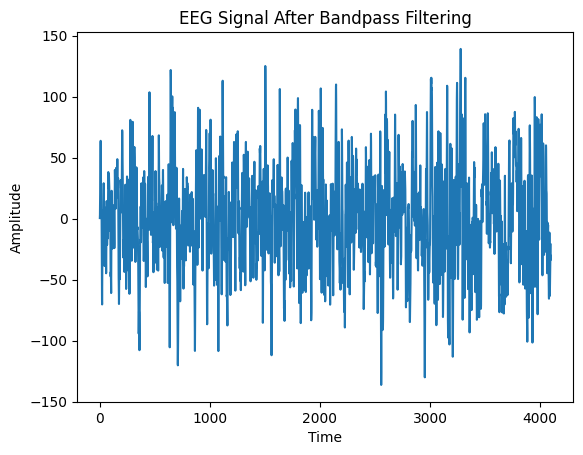

In [ ]:
plt.plot(filtered_data[0])
plt.title("EEG Signal After Bandpass Filtering")
plt.xlabel("Time")
plt.ylabel("Amplitude")
plt.show()

In [ ]:
# 2. Baseline correction: Remove DC offset
baseline = np.mean(filtered_data)
filtered_data -= baseline

In [ ]:
filtered_data

array([[  0.44541774,   3.15365921,  10.46685632, ..., -32.92602163,
        -33.96026033, -21.20918654],
       [ -2.03401041, -12.75212917, -34.89292765, ..., -40.29092709,
        -39.8323692 , -28.30180815],
       [ -1.34122901,  -8.02045701, -19.97431972, ...,  65.97210531,
         69.09203371,  73.5079577 ],
       ...,
       [ -0.39321237,  -2.97907655,  -9.76522541, ...,  35.96792985,
         21.73294784,  16.19599627],
       [  0.48187992,   3.34896085,  10.65526428, ...,  16.2496474 ,
         31.13741085,  45.63556016],
       [ -2.25278348, -14.43440952, -39.99731245, ...,  26.14735317,
         26.13348246,  24.5938288 ]])

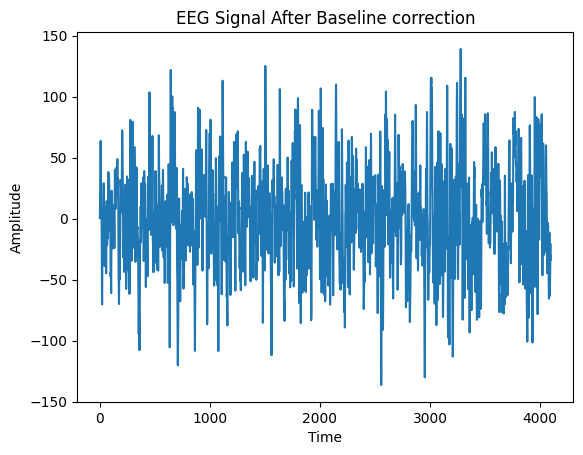

In [ ]:
plt.plot(filtered_data[0])
plt.title("EEG Signal After Baseline correction")
plt.xlabel("Time")
plt.ylabel("Amplitude")
plt.show()

In [ ]:
# 3. Normalization: Scale the data to a common range (e.g., -1 to 1)
max_abs = np.max(np.abs(filtered_data))
normalized_data = filtered_data / max_abs

# Preprocessed EEG data is now stored in `normalized_data`
print(normalized_data)

[[ 0.00017448  0.00123534  0.00410003 ... -0.01289764 -0.01330277
  -0.00830797]
 [-0.00079675 -0.00499521 -0.01366811 ... -0.01578259 -0.01560297
  -0.01108627]
 [-0.00052538 -0.00314174 -0.00782426 ...  0.02584232  0.02706444
   0.02879423]
 ...
 [-0.00015403 -0.00116695 -0.00382519 ...  0.01408921  0.00851314
   0.00634423]
 [ 0.00018876  0.00131184  0.00417384 ...  0.00636524  0.01219702
   0.01787617]
 [-0.00088245 -0.00565419 -0.01566758 ...  0.01024233  0.0102369
   0.00963379]]


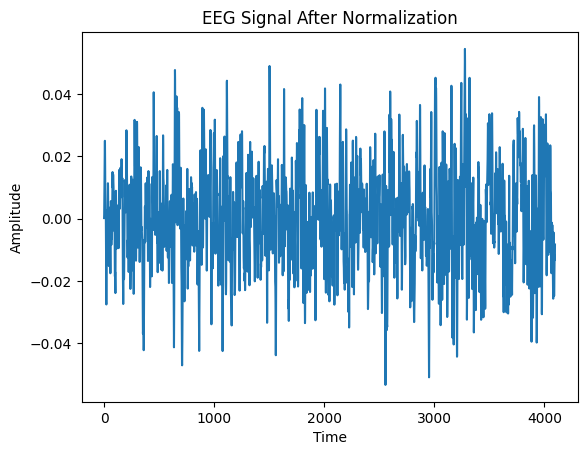

In [ ]:
plt.plot(normalized_data[0])
plt.title("EEG Signal After Normalization")
plt.xlabel("Time")
plt.ylabel("Amplitude")
plt.show()

# Binary Class Classification

### Model LSTM

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score

In [ ]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(filtered_data, labels, test_size=0.2, random_state=42)

In [ ]:
# Convert to NumPy arrays
X_train = np.array(X_train)
X_test = np.array(X_test)
y_train = np.array(y_train)
y_test = np.array(y_test)

In [ ]:
# Standardize the data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train).reshape(X_train.shape)
X_test = scaler.transform(X_test).reshape(X_test.shape)

In [ ]:
# Build the LSTM model
model = Sequential()
model.add(LSTM(64, input_shape=(4097, 1)))
model.add(Dense(1, activation='sigmoid'))

In [ ]:
# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 64)                16896     
                                                                 
 dense (Dense)               (None, 1)                 65        
                                                                 
Total params: 16961 (66.25 KB)
Trainable params: 16961 (66.25 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
# Train the model without using validation_split
history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test))

Epoch 1/10
13/13 [==============================] - 27s 2s/step - loss: 0.6813 - accuracy: 0.4950 - val_loss: 0.6675 - val_accuracy: 0.5700
Epoch 2/10
13/13 [==============================] - 26s 2s/step - loss: 0.6449 - accuracy: 0.6050 - val_loss: 0.6163 - val_accuracy: 0.5800
Epoch 3/10
13/13 [==============================] - 36s 3s/step - loss: 0.6020 - accuracy: 0.6075 - val_loss: 0.7924 - val_accuracy: 0.6300
Epoch 4/10
13/13 [==============================] - 41s 3s/step - loss: 0.5875 - accuracy: 0.6475 - val_loss: 0.5624 - val_accuracy: 0.6600
Epoch 5/10
13/13 [==============================] - 47s 4s/step - loss: 0.5617 - accuracy: 0.6575 - val_loss: 0.4985 - val_accuracy: 0.7400
Epoch 6/10
13/13 [==============================] - 37s 3s/step - loss: 0.5348 - accuracy: 0.7200 - val_loss: 0.4604 - val_accuracy: 0.7700
Epoch 7/10
13/13 [==============================] - 24s 2s/step - loss: 0.5349 - accuracy: 0.7125 - val_loss: 0.4697 - val_accuracy: 0.7700
Epoch 8/10
13/13 [==

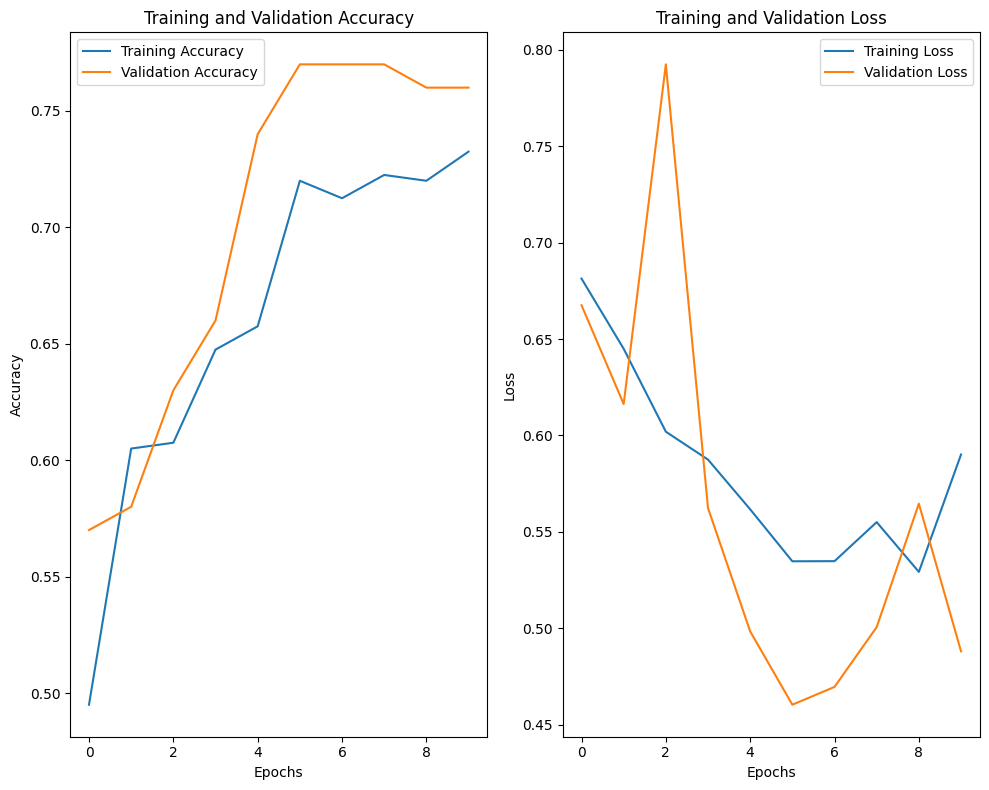

In [ ]:
# Plot training and validation accuracy over epochs
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 8))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plot training and validation loss over epochs
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
# Evaluate the model on the test set
y_pred = (model.predict(X_test) > 0.5).astype(int)
accuracy = accuracy_score(y_test, y_pred)
print(f"Test Accuracy: {accuracy}")

4/4 [==============================] - 2s 408ms/step
Test Accuracy: 0.76


In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
report = classification_report(y_test, y_pred, target_names=['Healthy','Seizure'])
print("Classification Report:\n", report)

# Generate and print the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:\n", conf_matrix)

Classification Report:
               precision    recall  f1-score   support

     Healthy       0.68      0.81      0.74        42
     Seizure       0.84      0.72      0.78        58

    accuracy                           0.76       100
   macro avg       0.76      0.77      0.76       100
weighted avg       0.77      0.76      0.76       100

Confusion Matrix:
 [[34  8]
 [16 42]]


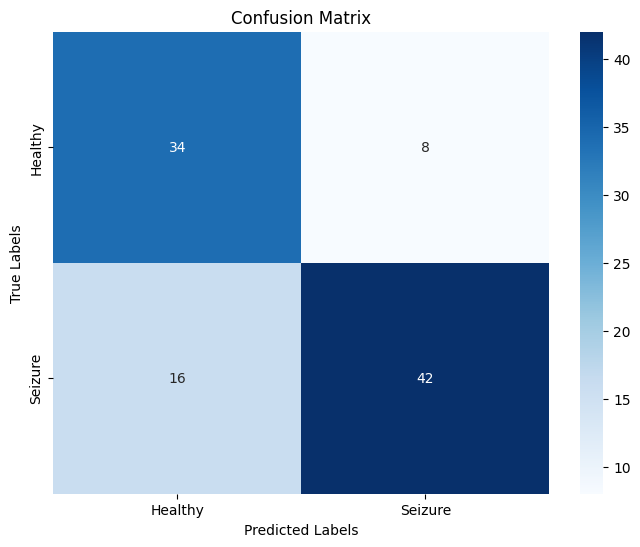

In [ ]:
import seaborn as sns
# Plot the heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Healthy','Seizure'], yticklabels=['Healthy','Seizure'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

### Model LSTM+CNN

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Conv1D, MaxPooling1D, Flatten, Dense
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score

In [ ]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(filtered_data, labels, test_size=0.2, random_state=42)

In [ ]:
# Convert to NumPy arrays
X_train = np.array(X_train)
X_test = np.array(X_test)
y_train = np.array(y_train)
y_test = np.array(y_test)

In [ ]:
# Standardize the data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train).reshape(X_train.shape)
X_test = scaler.transform(X_test).reshape(X_test.shape)

In [ ]:
# Build the combined LSTM and CNN model
model = Sequential()
model.add(Conv1D(32, kernel_size=3, activation='relu', input_shape=(4097, 1)))
model.add(MaxPooling1D(pool_size=2))
model.add(LSTM(64, return_sequences=True))
model.add(Flatten())
model.add(Dense(1, activation='sigmoid'))

In [ ]:
# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


In [ ]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 4095, 32)          128       
                                                                 
 max_pooling1d (MaxPooling1  (None, 2047, 32)          0         
 D)                                                              
                                                                 
 lstm_2 (LSTM)               (None, 2047, 64)          24832     
                                                                 
 flatten (Flatten)           (None, 131008)            0         
                                                                 
 dense_2 (Dense)             (None, 1)                 131009    
                                                                 
Total params: 155969 (609.25 KB)
Trainable params: 155969 (609.25 KB)
Non-trainable params: 0 (0.00 Byte)
______________

In [ ]:
# Train the model without using validation_split
history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test))

Epoch 1/10
13/13 [==============================] - 29s 2s/step - loss: 0.6338 - accuracy: 0.6275 - val_loss: 0.4499 - val_accuracy: 0.8100
Epoch 2/10
13/13 [==============================] - 24s 2s/step - loss: 0.4201 - accuracy: 0.8150 - val_loss: 0.5115 - val_accuracy: 0.7400
Epoch 3/10
13/13 [==============================] - 27s 2s/step - loss: 0.3164 - accuracy: 0.8800 - val_loss: 0.2707 - val_accuracy: 0.8800
Epoch 4/10
13/13 [==============================] - 26s 2s/step - loss: 0.1822 - accuracy: 0.9575 - val_loss: 0.1978 - val_accuracy: 0.9300
Epoch 5/10
13/13 [==============================] - 27s 2s/step - loss: 0.1432 - accuracy: 0.9700 - val_loss: 0.1259 - val_accuracy: 0.9600
Epoch 6/10
13/13 [==============================] - 26s 2s/step - loss: 0.1167 - accuracy: 0.9625 - val_loss: 0.2405 - val_accuracy: 0.8900
Epoch 7/10
13/13 [==============================] - 25s 2s/step - loss: 0.1037 - accuracy: 0.9725 - val_loss: 0.1787 - val_accuracy: 0.9100
Epoch 8/10
13/13 [==

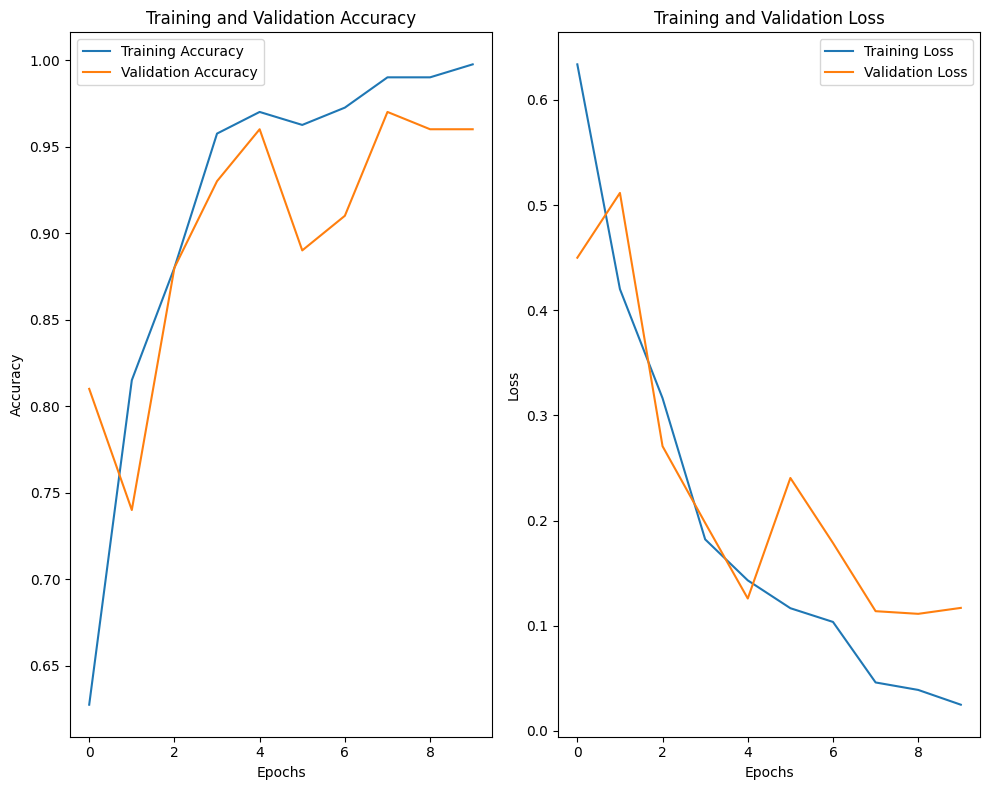

In [ ]:
# Plot training and validation accuracy over epochs
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 8))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plot training and validation loss over epochs
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
# Evaluate the model on the test set
y_pred = (model.predict(X_test) > 0.5).astype(int)
accuracy = accuracy_score(y_test, y_pred)
print(f"Test Accuracy: {accuracy}")

4/4 [==============================] - 2s 268ms/step
Test Accuracy: 0.96


In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
report = classification_report(y_test, y_pred, target_names=['Healthy','Seizure'])
print("Classification Report:\n", report)

# Generate and print the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:\n", conf_matrix)

Classification Report:
               precision    recall  f1-score   support

     Healthy       0.97      0.93      0.95        42
     Seizure       0.95      0.98      0.97        58

    accuracy                           0.96       100
   macro avg       0.96      0.96      0.96       100
weighted avg       0.96      0.96      0.96       100

Confusion Matrix:
 [[39  3]
 [ 1 57]]


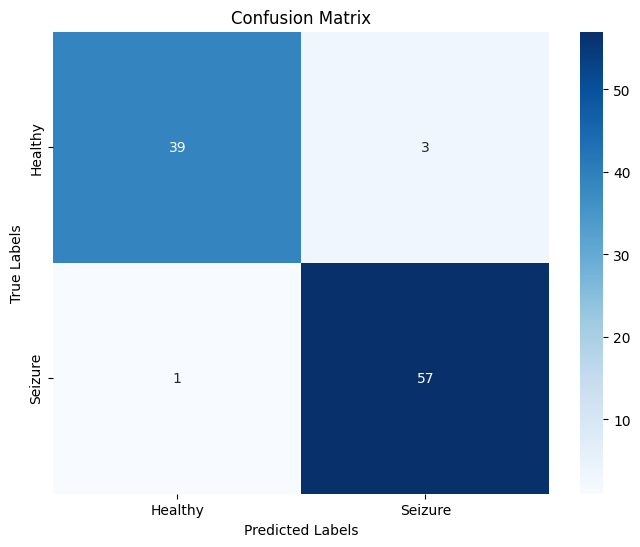

In [ ]:
import seaborn as sns
# Plot the heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Healthy','Seizure'], yticklabels=['Healthy','Seizure'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

# Multi Class Classification

### Model LSTM

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score

In [ ]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(filtered_data, tri_labels, test_size=0.2, random_state=42)

In [ ]:
# Convert to NumPy arrays
X_train = np.array(X_train)
X_test = np.array(X_test)
y_train = np.array(y_train)
y_test = np.array(y_test)

In [ ]:
# Standardize the data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train).reshape(X_train.shape)
X_test = scaler.transform(X_test).reshape(X_test.shape)

In [ ]:
# Build the LSTM model
model = Sequential()
model.add(LSTM(64, input_shape=(4097, 1)))
model.add(Dense(3, activation='sigmoid'))

In [ ]:
# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [ ]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_3 (LSTM)               (None, 64)                16896     
                                                                 
 dense_3 (Dense)             (None, 3)                 195       
                                                                 
Total params: 17091 (66.76 KB)
Trainable params: 17091 (66.76 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
# Train the model without using validation_split
history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test))

Epoch 1/10
13/13 [==============================] - 32s 2s/step - loss: 1.0884 - accuracy: 0.4200 - val_loss: 1.0511 - val_accuracy: 0.4600
Epoch 2/10
13/13 [==============================] - 29s 2s/step - loss: 0.9976 - accuracy: 0.5025 - val_loss: 0.8635 - val_accuracy: 0.4700
Epoch 3/10
13/13 [==============================] - 24s 2s/step - loss: 0.8179 - accuracy: 0.5450 - val_loss: 0.7475 - val_accuracy: 0.5100
Epoch 4/10
13/13 [==============================] - 36s 3s/step - loss: 0.7835 - accuracy: 0.5550 - val_loss: 0.6959 - val_accuracy: 0.6200
Epoch 5/10
13/13 [==============================] - 42s 3s/step - loss: 0.7530 - accuracy: 0.5800 - val_loss: 0.6921 - val_accuracy: 0.6500
Epoch 6/10
13/13 [==============================] - 30s 2s/step - loss: 0.7559 - accuracy: 0.5525 - val_loss: 0.6688 - val_accuracy: 0.6600
Epoch 7/10
13/13 [==============================] - 28s 2s/step - loss: 0.7718 - accuracy: 0.6125 - val_loss: 0.7822 - val_accuracy: 0.6400
Epoch 8/10
13/13 [==

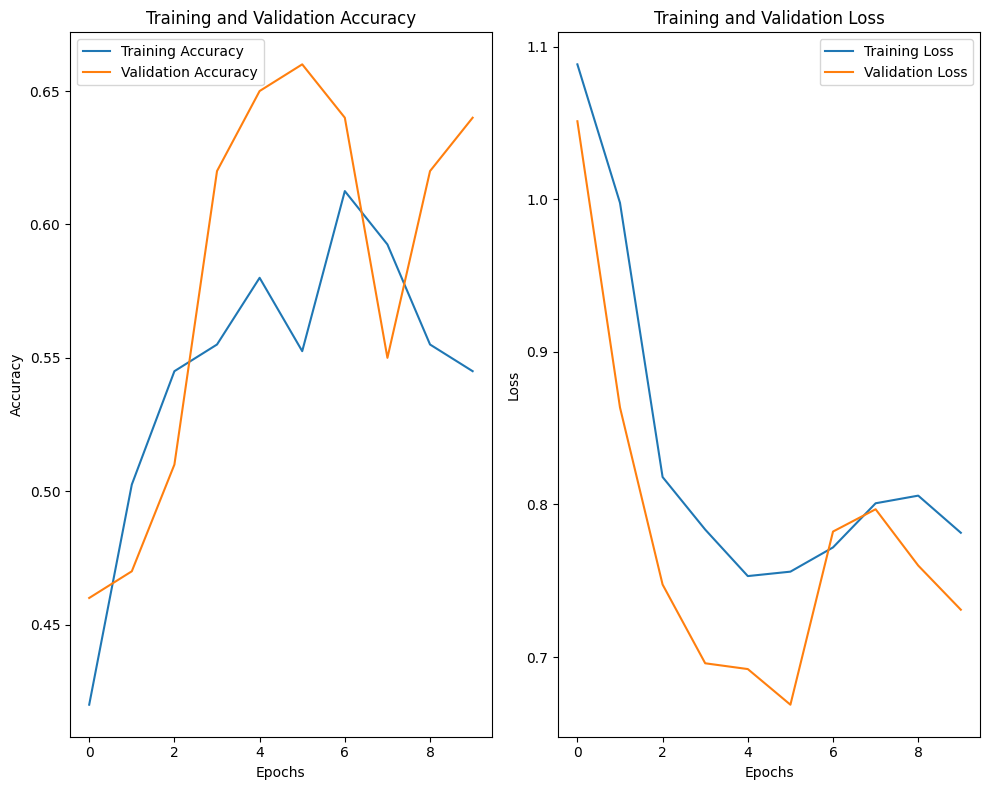

In [ ]:
# Plot training and validation accuracy over epochs
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 8))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plot training and validation loss over epochs
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
# Evaluate the model on the test set
y_pred = np.argmax(model.predict(X_test), axis=1)
accuracy = accuracy_score(y_test, y_pred)
print(f"Test Accuracy: {accuracy}")

4/4 [==============================] - 2s 452ms/step
Test Accuracy: 0.64


In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
report = classification_report(y_test, y_pred, target_names=['Healthy','Mild Seizure','Seizure'])
print("Classification Report:\n", report)

# Generate and print the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:\n", conf_matrix)

Classification Report:
               precision    recall  f1-score   support

     Healthy       0.67      0.86      0.75        42
Mild Seizure       0.57      0.12      0.20        34
     Seizure       0.62      1.00      0.76        24

    accuracy                           0.64       100
   macro avg       0.62      0.66      0.57       100
weighted avg       0.62      0.64      0.56       100

Confusion Matrix:
 [[36  3  3]
 [18  4 12]
 [ 0  0 24]]


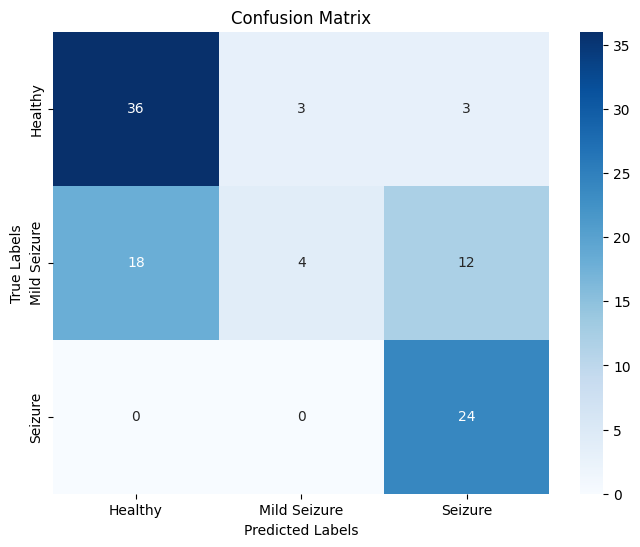

In [ ]:
import seaborn as sns
# Plot the heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Healthy','Mild Seizure','Seizure'], yticklabels=['Healthy','Mild Seizure','Seizure'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

### Model LSTM+CNN

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Conv1D, MaxPooling1D, Flatten, Dense
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score

In [ ]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(filtered_data, tri_labels, test_size=0.2, random_state=42)

In [ ]:
# Convert to NumPy arrays
X_train = np.array(X_train)
X_test = np.array(X_test)
y_train = np.array(y_train)
y_test = np.array(y_test)

In [ ]:
# Standardize the data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train).reshape(X_train.shape)
X_test = scaler.transform(X_test).reshape(X_test.shape)

In [ ]:
# Build the combined LSTM and CNN model
model = Sequential()
model.add(Conv1D(32, kernel_size=3, activation='relu', input_shape=(4097, 1)))
model.add(MaxPooling1D(pool_size=2))
model.add(LSTM(64, return_sequences=True))
model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dense(3, activation='softmax'))  # Output layer for multi-class classification

In [ ]:
# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [ ]:
model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_1 (Conv1D)           (None, 4095, 32)          128       
                                                                 
 max_pooling1d_1 (MaxPoolin  (None, 2047, 32)          0         
 g1D)                                                            
                                                                 
 lstm_7 (LSTM)               (None, 2047, 64)          24832     
                                                                 
 flatten_1 (Flatten)         (None, 131008)            0         
                                                                 
 dense_6 (Dense)             (None, 64)                8384576   
                                                                 
 dense_7 (Dense)             (None, 3)                 195       
                                                      

In [ ]:
# Train the model without using validation_split
history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test))

Epoch 1/10
13/13 [==============================] - 34s 2s/step - loss: 2.0660 - accuracy: 0.4225 - val_loss: 1.0349 - val_accuracy: 0.3400
Epoch 2/10
13/13 [==============================] - 27s 2s/step - loss: 0.6727 - accuracy: 0.6350 - val_loss: 0.6189 - val_accuracy: 0.6200
Epoch 3/10
13/13 [==============================] - 27s 2s/step - loss: 0.3589 - accuracy: 0.7975 - val_loss: 0.3782 - val_accuracy: 0.8900
Epoch 4/10
13/13 [==============================] - 25s 2s/step - loss: 0.1213 - accuracy: 0.9675 - val_loss: 0.1686 - val_accuracy: 0.9300
Epoch 5/10
13/13 [==============================] - 28s 2s/step - loss: 0.0266 - accuracy: 0.9925 - val_loss: 0.1348 - val_accuracy: 0.9400
Epoch 6/10
13/13 [==============================] - 27s 2s/step - loss: 0.0232 - accuracy: 0.9975 - val_loss: 0.1026 - val_accuracy: 0.9500
Epoch 7/10
13/13 [==============================] - 25s 2s/step - loss: 0.0087 - accuracy: 1.0000 - val_loss: 0.1225 - val_accuracy: 0.9600
Epoch 8/10
13/13 [==

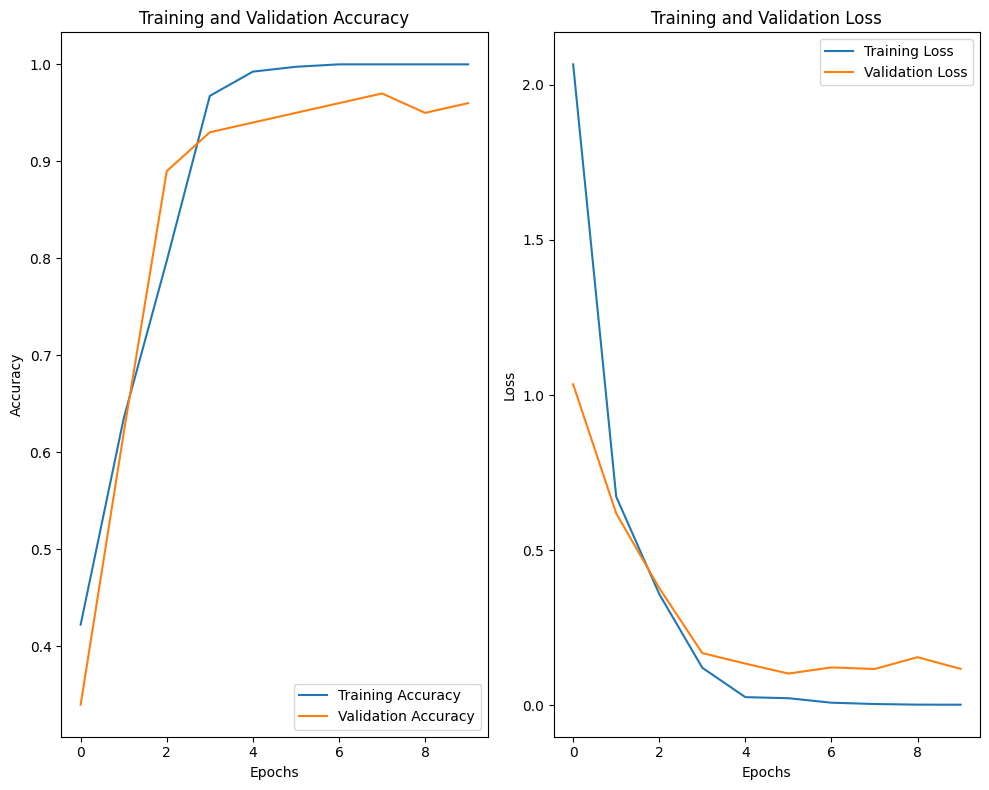

In [ ]:
# Plot training and validation accuracy over epochs
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 8))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plot training and validation loss over epochs
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
# Evaluate the model on the test set
y_pred = np.argmax(model.predict(X_test), axis=1)
accuracy = accuracy_score(y_test, y_pred)
print(f"Test Accuracy: {accuracy}")

4/4 [==============================] - 2s 515ms/step
Test Accuracy: 0.96


In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
report = classification_report(y_test, y_pred, target_names=['Healthy','Mild Seizure','Seizure'])
print("Classification Report:\n", report)

# Generate and print the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:\n", conf_matrix)

Classification Report:
               precision    recall  f1-score   support

     Healthy       0.95      0.95      0.95        42
Mild Seizure       0.94      0.94      0.94        34
     Seizure       1.00      1.00      1.00        24

    accuracy                           0.96       100
   macro avg       0.96      0.96      0.96       100
weighted avg       0.96      0.96      0.96       100

Confusion Matrix:
 [[40  2  0]
 [ 2 32  0]
 [ 0  0 24]]


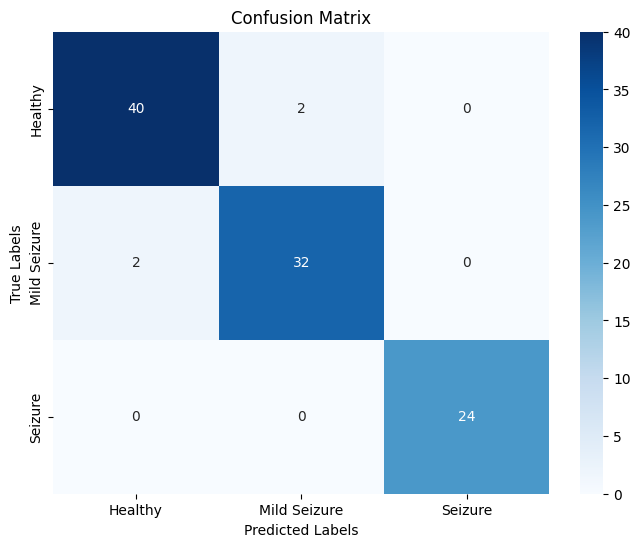

In [ ]:
import seaborn as sns
# Plot the heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Healthy','Mild Seizure','Seizure'], yticklabels=['Healthy','Mild Seizure','Seizure'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()